In [1]:
#!/usr/bin/env python
# coding: utf-8
# (c) Charles Le Losq, Clément Ferraina 2023-2024
# see embedded licence file

#
# Library Loading
#
import pandas as pd # manipulate dataframes
import matplotlib.pyplot as plt # plotting
import numpy as np
np.random.seed = 167 # fix random seed for reproducibility

# local imports
import gpvisc

from sklearn.preprocessing import StandardScaler
import joblib

# CPU or GPU?
device = gpvisc.get_device()

Will run on cuda


# Loading data and models

In [2]:
# Data loading
print("Loading the viscosity datasets...")
ds = gpvisc.data_loader()

# Add scalers
ds.scaler_tpx = StandardScaler().fit(ds.TPX_train_valid[:,:14]) # for the blackbox model

print("Loading the models...")
#Linear Regression
clf_linreg = joblib.load('./models/clf_linreg.joblib')

# Support Vector Machine regression
clf_svr = joblib.load('./models/clf_svr.joblib')

# Artificial Neural Network
clf_nn = joblib.load('./models/clf_nn.joblib')

# Random Forest Regressor
clf_rf = joblib.load('./models/clf_rf.joblib')

# Greybox ANN and GP
gp_model, likelihood = gpvisc.load_gp_model(model_number=1, device=device)

print('Loaded.')

Loading the viscosity datasets...
Loading the models...


/home/charles/miniconda3/envs/gpytorch/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LinearRegression from version 1.5.0 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/charles/miniconda3/envs/gpytorch/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator SVR from version 1.5.0 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/charles/miniconda3/envs/gpytorch/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MLPRegressor from ver

Loaded.


# Figures showing the behavior in temperature, pressure and composition

In [3]:
def predict_one_compo(di_, # subset
                      ds, # data object
                      T_interest,
                      P_interest):

    # check composition
    di_ = gpvisc.chimie_control(di_).copy()
    
    # add descriptors
    #xi_ = gpvisc.descriptors(di_.loc[:, gpvisc.list_oxides()])

    # same composition so we get first line, then create an array with interesting temps
    #xi = np.ones((len(T_interest),di_.shape[1]))*di_.loc[[0],gpvisc.list_oxides()].values

    # transformation
    tpxi_scaled = gpvisc.scale_for_blackbox(T_interest, 
                                            P_interest, 
                                            di_.loc[[0],gpvisc.list_oxides()], 
                                            ds.scaler_tpx)
    
    tpx_for_gp = gpvisc.scale_for_gaussianprocess(T_interest, 
                                                 P_interest,
                                                 di_.loc[[0],gpvisc.list_oxides()])
    
    # predictions 
    oneC_lin = clf_linreg.predict(tpxi_scaled)
    oneC_svr = clf_svr.predict(tpxi_scaled)
    oneC_nn = clf_nn.predict(tpxi_scaled)
    oneC_rf = clf_rf.predict(tpxi_scaled)
    oneC_grey = gpvisc.predict(tpx_for_gp, gp_model, likelihood, model_to_use="ann", device=device) 
    y_gp_mean, y_gp_std = gpvisc.predict(tpx_for_gp, gp_model, likelihood, model_to_use="gp", device=device) 
    oneC_gp = [y_gp_mean, y_gp_mean-y_gp_std, y_gp_mean+y_gp_std]
    
    predictions = (oneC_lin, oneC_svr, oneC_rf, oneC_nn, oneC_grey, oneC_gp)
    return predictions

dataset_albite = ds.dataset_lp.loc[(ds.dataset_lp.Name_publi=="An0")|(ds.dataset_lp.Name_publi=="NAK75_12_0")|
                     (ds.dataset_lp.Name_publi=="Ab"),:].reset_index()

dataset_albite_hp = ds.dataset_hp.loc[ds.dataset_hp.Compo_interest=="albite",:].reset_index()

dataset_peridotite = ds.dataset_lp.loc[(ds.dataset_lp.Name_publi=="Pr"),:].reset_index()
dataset_anorthite = ds.dataset_lp.loc[(ds.dataset_lp.Name_publi=="An100")|(ds.dataset_lp.Name_publi=="An")|
                     (ds.dataset_lp.Name_publi=="Anorthite"),:].reset_index()

# our pressure and temperature ranges of interest
T_interest = np.arange(1000,2500,20).reshape(-1,1)
P_interest = np.zeros(len(T_interest)).reshape(-1,1)

predictions_albite = predict_one_compo(dataset_albite, ds, T_interest, P_interest)
predictions_peridotite = predict_one_compo(dataset_peridotite, ds, T_interest, P_interest)
predictions_anorthite = predict_one_compo(dataset_anorthite, ds, T_interest, P_interest)

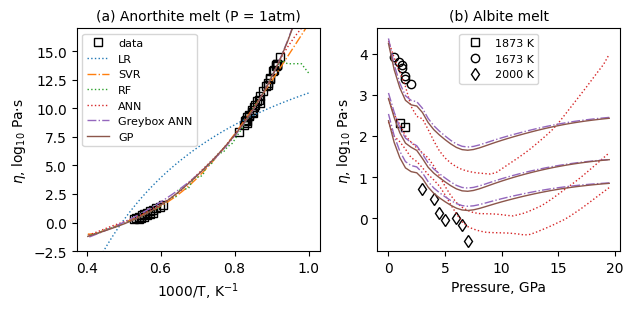

In [4]:
#
# And final figure !
#
lines = [":","-.",":",":","-.","-","-"]
names=["LR","SVR","RF","ANN","Greybox ANN", "GP","G2008"]
colors=["C0","C1","C2","C3","C4","C5","C6"]

plt.figure(figsize=(6.44,3.22))

###
# TEMPERATURE SUBPLOT
###
plt.subplot(1,2,1)
plt.title("(a) Anorthite melt (P = 1atm)", fontsize=10)

# plotting data
plt.plot(1000/dataset_anorthite["T"], 
         dataset_anorthite["viscosity"],
         "ks", markerfacecolor="none", label="data")

# plotting predictions
for count,i in enumerate(predictions_anorthite):
    if count == 5:
        plt.plot(1000/T_interest, i[0], linestyle=lines[count], 
                 linewidth=1.0,
                 label=names[count], color=colors[count])
    else:
        plt.plot(1000/T_interest, i, linestyle=lines[count], 
                 linewidth=1.0,
                 label=names[count], color=colors[count])

plt.xlabel("1000/T, K$^{-1}$")
plt.ylabel("$\eta$, log$_{10}$ Pa$\cdot$s")
plt.legend(loc="best", fontsize=8)
plt.ylim(-2.5,17)

###
# PRESSURE SUBPLOT
###
plt.subplot(1,2,2)
plt.title("(b) Albite melt", fontsize=10)
P_interest = np.arange(0,20.,0.5)

# plotting data
plt.plot(dataset_albite_hp.loc[dataset_albite_hp["T"]==1873,"P"], 
         dataset_albite_hp.loc[dataset_albite_hp["T"]==1873, "viscosity"], "ks", 
         markerfacecolor="none", label="1873 K")
plt.plot(dataset_albite_hp.loc[dataset_albite_hp["T"]==1673,"P"], 
         dataset_albite_hp.loc[dataset_albite_hp["T"]==1673, "viscosity"], "ko", 
         markerfacecolor="none", label="1673 K")
plt.plot(dataset_albite_hp.loc[dataset_albite_hp["T"]==2000,"P"], 
         dataset_albite_hp.loc[dataset_albite_hp["T"]==2000, "viscosity"], "kd", 
         markerfacecolor="none", label="2000 K")
plt.legend(fontsize=8)


# plotting predictions
for i in [1873, 1673, 2000]:
    predictions_albite_hp_ = predict_one_compo(dataset_albite_hp.loc[dataset_albite_hp["T"]==i,:].reset_index(), 
                                               ds, i*np.ones(len(P_interest)), P_interest)

    # we only plot the interesting models
    for j in range(3,len(predictions_albite_hp_)):
        if j == 5:
            plt.plot(P_interest, predictions_albite_hp_[j][0], 
                     linewidth=1.0,
                     linestyle=lines[j], label=names[j], color=colors[j])
        else:
            plt.plot(P_interest, predictions_albite_hp_[j], 
                     linewidth=1.0,
                     linestyle=lines[j], label=names[j], color=colors[j])

plt.ylabel("$\eta$, log$_{10}$ Pa$\cdot$s")
plt.xlabel("Pressure, GPa")
plt.tight_layout()
plt.savefig("./figures/Figure2.pdf")

# Figure for presentations

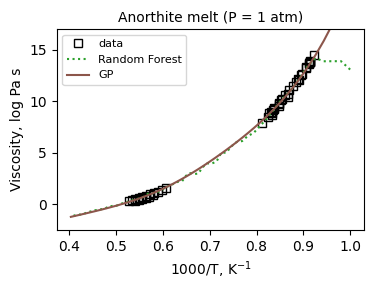

In [5]:
#
# And final figure !
#
lines = [":","-.",":",":","--","-"]
names=["LR","SVR","Random Forest","ANN","Greybox Neural Network", "GP"]
colors=["C0","C1","C2","C3","C4","C5"]

plt.figure(figsize=(4,3))

###
# TEMPERATURE SUBPLOT
###
plt.subplot()
plt.title("Anorthite melt (P = 1 atm)", fontsize=10)
plt.plot(1000/dataset_anorthite["T"], dataset_anorthite["viscosity"],"ks", markerfacecolor="none", label="data")
plt.plot(1000/T_interest, predictions_anorthite[2], linestyle=lines[2], label=names[2], color=colors[2])
plt.plot(1000/T_interest, predictions_anorthite[5][0], linestyle=lines[5], label=names[5], color=colors[5])

plt.xlabel("1000/T, K$^{-1}$")
plt.ylabel("Viscosity, log Pa s")
plt.legend(loc="best", fontsize=8)
plt.ylim(-2.5,17)

plt.tight_layout()
plt.savefig("./figures/Figure2a_forpresentations.pdf")

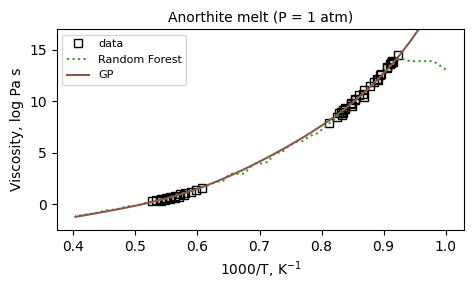

In [6]:
#
# And final figure !
#
lines = [":","-.",":",":","--","-"]
names=["LR","SVR","Random Forest","ANN","Greybox Neural Network", "GP"]
colors=["C0","C1","C2","C3","C4","C5"]

plt.figure(figsize=(5,3))

###
# TEMPERATURE SUBPLOT
###
plt.subplot()
plt.title("Anorthite melt (P = 1 atm)", fontsize=10)
plt.plot(1000/dataset_anorthite["T"], dataset_anorthite["viscosity"],"ks", markerfacecolor="none", label="data")
plt.plot(1000/T_interest, predictions_anorthite[2], linestyle=lines[2], label=names[2], color=colors[2])
plt.plot(1000/T_interest, predictions_anorthite[5][0], linestyle=lines[5], label=names[5], color=colors[5])

plt.xlabel("1000/T, K$^{-1}$")
plt.ylabel("Viscosity, log Pa s")
plt.legend(loc="best", fontsize=8)
plt.ylim(-2.5,17)

plt.tight_layout()
plt.savefig("./figures/Figure2b_forpresentations.pdf")

## Comparison with Giordano et al. 2008

In [7]:
dataset_lp = gpvisc.chimie_control(ds.dataset_lp.copy())

# make predictions with GP model directly
TPX_lp = gpvisc.scale_for_gaussianprocess(dataset_lp["T"],
                                          dataset_lp["T"]*0.0,
                                          dataset_lp)

GP_preds, GP_preds_std = gpvisc.predict(TPX_lp, gp_model, likelihood, device=device)

# now apply the Giordano model
# warning we must bring together FeO and Fe2O3
dataset_lp["feo"] = dataset_lp["feo"]+2*dataset_lp["fe2o3"]
dataset_lp["fe2o3"] = 0.0 # We set Fe2O3 to 0
dataset_lp = gpvisc.chimie_control(dataset_lp)
G2008_preds = gpvisc.G2008(dataset_lp.loc[:, ['sio2', 'tio2', 'al2o3', 'feo', 'fe2o3', 'mno', 'na2o', 'k2o',
       'mgo', 'cao', 'p2o5', 'h2o','T']])

### Predictions versus measurements - general comparison at 1 atm

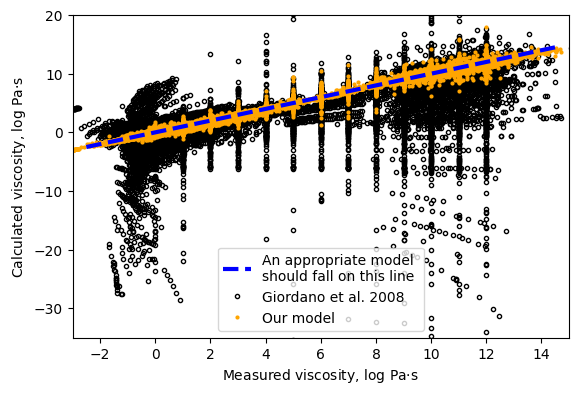

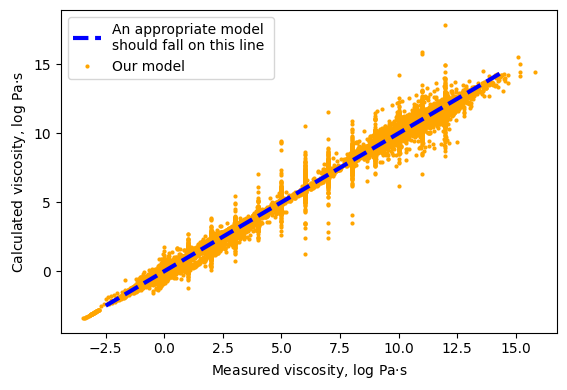

In [8]:
plt.figure(figsize=(6,4))
plt.plot([-2.5,14.5], [-2.5,14.5],"--", color="blue", linewidth=3.0, label="An appropriate model \nshould fall on this line", zorder=2)
plt.legend()

plt.xlabel("Measured viscosity, log Pa$\cdot$s")
plt.ylabel("Calculated viscosity, log Pa$\cdot$s")

plt.tight_layout()
plt.savefig("./figures/Comparison_Giordano_a.pdf")

plt.plot(dataset_lp["viscosity"], G2008_preds[0],".", markerfacecolor="none", markeredgecolor="black", label="Giordano et al. 2008", zorder=0)
plt.xlim(-3,15)
plt.ylim(-35,20)

plt.legend()

plt.savefig("./figures/Comparison_Giordano_b.pdf")

plt.plot(dataset_lp["viscosity"], GP_preds,".", markerfacecolor="orange", markeredgecolor="none", label="Our model", zorder=1)
plt.legend()
plt.savefig("./figures/Comparison_Giordano_c.pdf")

plt.figure(figsize=(6,4))
plt.plot([-2.5,14.5], [-2.5,14.5],"--", color="blue", linewidth=3.0, label="An appropriate model \nshould fall on this line", zorder=2)
plt.legend()

plt.xlabel("Measured viscosity, log Pa$\cdot$s")
plt.ylabel("Calculated viscosity, log Pa$\cdot$s")

plt.tight_layout()
plt.plot(dataset_lp["viscosity"], GP_preds,".", markerfacecolor="orange", markeredgecolor="none", label="Our model", zorder=1)
plt.legend()
plt.savefig("./figures/Comparison_Giordano_d.pdf")


## Predictions versus measurements -- Case by case comparison on interesting compositions

Calculation iron redox...


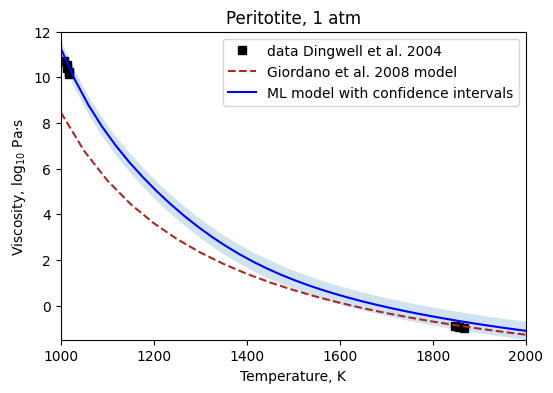

In [9]:
T_interest = np.arange(1000,3000,50).reshape(-1,1)

X_peridotite = gpvisc.generate_query_single(sio2=dataset_peridotite.loc[0, "sio2"],
                                     tio2=dataset_peridotite.loc[0, "tio2"],
                                     al2o3=dataset_peridotite.loc[0, "al2o3"],
                                     feo=dataset_peridotite.loc[0, "fe2o3"],
                                     mno=dataset_peridotite.loc[0, "mno"],
                                     na2o=dataset_peridotite.loc[0, "na2o"],
                                     k2o=dataset_peridotite.loc[0, "k2o"],
                                     mgo=dataset_peridotite.loc[0, "mgo"],
                                     cao=dataset_peridotite.loc[0, "cao"],
                                     p2o5=dataset_peridotite.loc[0, "p2o5"],
                                     h2o=dataset_peridotite.loc[0, "h2o"],
                                     composition_mole = True,
                                     T_init = 1000.0, T_final= 60000.0,
                                     P_init = 0.0, P_final = 0.0,
                                     control_redox = True,
                                     fo2_init = np.log10(0.21), fo2_final = np.log10(0.21),
                                     nb_values = 2000,
                                     )

TPX_peridotite = gpvisc.scale_for_gaussianprocess(X_peridotite["T"], X_peridotite["P"], X_peridotite)
gp_peridotite, gp_peridotite_std = gpvisc.predict(TPX_peridotite, gp_model, likelihood, device=device)

index_Pr = np.where(dataset_lp.Name_publi=="Pr")[0]

G2008_per = gpvisc.VFT(T_interest,  
       G2008_preds[2],
       G2008_preds[3][index_Pr[0]],
       G2008_preds[4][index_Pr[0]])

plt.figure(figsize=(6,4))
plt.plot(dataset_lp.loc[index_Pr,"T"], dataset_lp.loc[index_Pr,"viscosity"], "ks", label="data Dingwell et al. 2004")
plt.plot(T_interest, G2008_per, "--", color="brown", label="Giordano et al. 2008 model")

plt.ylim(-1.5,12)
plt.xlim(1000,2000)
plt.legend()
plt.title("Peritotite, 1 atm")
plt.xlabel("Temperature, K")
plt.ylabel("Viscosity, log$_{10}$ Pa$\cdot$s")
plt.savefig("./figures/Per_a.pdf")

plt.plot(X_peridotite["T"], gp_peridotite, "b-", label="ML model with confidence intervals")
plt.legend()
plt.fill_between(X_peridotite["T"], 
                 gp_peridotite-gp_peridotite_std,
                 gp_peridotite+gp_peridotite_std,
                 alpha=0.2)
plt.savefig("./figures/Per_b.pdf")

Calculation iron redox...


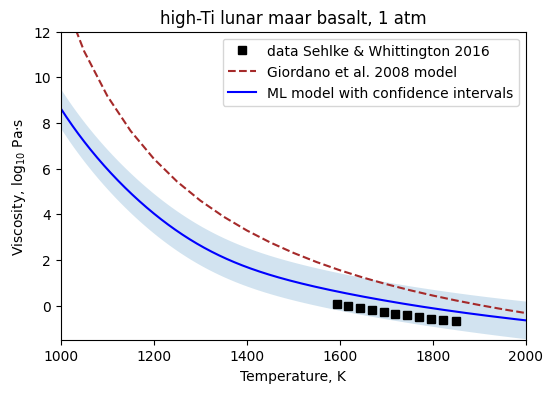

In [10]:
dataset_LM = ds.dataset_lp.loc[(ds.dataset_lp.Name_publi=="LM"),:].reset_index()

X_LM = gpvisc.generate_query_single(sio2=dataset_LM.loc[0, "sio2"],
                                     tio2=dataset_LM.loc[0, "tio2"],
                                     al2o3=dataset_LM.loc[0, "al2o3"],
                                     feo=dataset_LM.loc[0, "fe2o3"],
                                     mno=dataset_LM.loc[0, "mno"],
                                     na2o=dataset_LM.loc[0, "na2o"],
                                     k2o=dataset_LM.loc[0, "k2o"],
                                     mgo=dataset_LM.loc[0, "mgo"],
                                     cao=dataset_LM.loc[0, "cao"],
                                     p2o5=dataset_LM.loc[0, "p2o5"],
                                     h2o=dataset_LM.loc[0, "h2o"],
                                     composition_mole = True,
                                     T_init = 1000.0, T_final= 3000.0,
                                     P_init = 0.0, P_final = 0.0,
                                     control_redox = True,
                                     fo2_init = 0.67, fo2_final = 0.67,
                                     nb_values = 3000,
                                     )

TPX_LM = gpvisc.scale_for_gaussianprocess(X_LM["T"], X_LM["P"], X_LM)
gp_LM, gp_LM_std = gpvisc.predict(TPX_LM, gp_model, likelihood, device=device)

index_LM = np.where(dataset_lp.Name_publi=="LM")[0]

G2008_LM = gpvisc.VFT(T_interest,  
       G2008_preds[2],
       G2008_preds[3][index_LM[0]],
       G2008_preds[4][index_LM[0]])


plt.figure(figsize=(6,4))
plt.plot(dataset_lp.loc[index_LM,"T"], dataset_lp.loc[index_LM,"viscosity"], "ks", label="data Sehlke & Whittington 2016")
plt.plot(T_interest, G2008_LM, "--", color="brown", label="Giordano et al. 2008 model")
#plt.plot(dataset_lp.loc[index_Pr,"T"], GP_preds.numpy()[index_Pr], "bx")
plt.ylim(-1.5,12)
plt.xlim(1000,2000)
plt.legend()
plt.title("high-Ti lunar maar basalt, 1 atm")
plt.xlabel("Temperature, K")
plt.ylabel("Viscosity, log$_{10}$ Pa$\cdot$s")

plt.savefig("./figures/LM_a.pdf")

plt.plot(X_LM["T"], gp_LM, "b-", label="ML model with confidence intervals")
plt.legend()
plt.fill_between(X_LM["T"], 
                 gp_LM - gp_LM_std*2,
                 gp_LM + gp_LM_std*2,
                 alpha=0.2)
plt.savefig("./figures/LM_b.pdf")

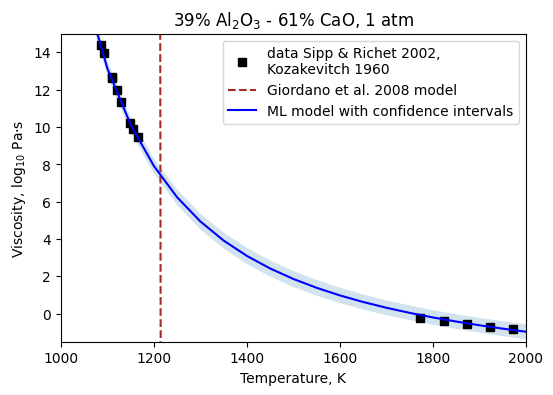

In [11]:
dataset_CA = ds.dataset_lp.loc[(ds.dataset_lp.Name_publi=="Ca0.39")|(ds.dataset_lp.Name_publi=="ACS-18"),:].reset_index()
predictions_CA = predict_one_compo(dataset_CA, ds, T_interest, np.zeros(len(T_interest)))

index_CA = np.where((ds.dataset_lp.Name_publi=="Ca0.39")|(ds.dataset_lp.Name_publi=="ACS-18"))[0]

G2008_CA = gpvisc.VFT(T_interest,  
       G2008_preds[2],
       G2008_preds[3][index_CA[0]],
       G2008_preds[4][index_CA[0]])

plt.figure(figsize=(6,4))
plt.plot(dataset_lp.loc[index_CA,"T"], dataset_lp.loc[index_CA,"viscosity"], "ks", label="data Sipp & Richet 2002, \nKozakevitch 1960")
plt.plot(T_interest, G2008_CA, "--", color="brown", label="Giordano et al. 2008 model")
plt.ylim(-1.5,15)
plt.xlim(1000,2000)
plt.legend()
plt.title("39% Al$_2$O$_3$ - 61% CaO, 1 atm")
plt.xlabel("Temperature, K")
plt.ylabel("Viscosity, log$_{10}$ Pa$\cdot$s")

plt.savefig("./figures/CA_a.pdf")

plt.plot(T_interest, predictions_CA[5][0], "b-", label="ML model with confidence intervals")
plt.legend()
plt.fill_between(T_interest.ravel(), 
                 predictions_CA[5][1].ravel(),
                 predictions_CA[5][2].ravel(),
                 alpha=0.2)
plt.savefig("./figures/CA_b.pdf")

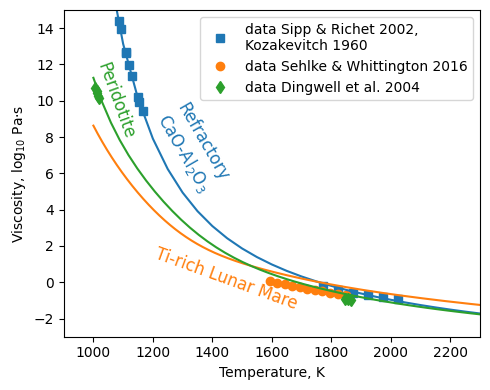

In [12]:
plt.figure(figsize=(5,4))
plt.plot(dataset_lp.loc[index_CA,"T"], dataset_lp.loc[index_CA,"viscosity"], "s", label="data Sipp & Richet 2002, \nKozakevitch 1960")
plt.plot(dataset_lp.loc[index_LM,"T"], dataset_lp.loc[index_LM,"viscosity"], "o", label="data Sehlke & Whittington 2016")
plt.plot(dataset_lp.loc[index_Pr,"T"], dataset_lp.loc[index_Pr,"viscosity"], "d", label="data Dingwell et al. 2004")
plt.legend()

plt.plot(T_interest, predictions_CA[5][0], "-",color="C0" , label="ML model with confidence intervals")
#plt.fill_between(T_interest.ravel(), 
#                 predictions_CA[5][1].numpy().ravel(),
#                 predictions_CA[5][2].numpy().ravel(),
#                 alpha=0.2,color="C0")
plt.plot(X_LM["T"], gp_LM, "-",color="C1" , label="ML model with confidence intervals")
#plt.fill_between(T_interest.ravel(), 
#                 predictions_LM[5][1].numpy().ravel(),
#                 predictions_LM[5][2].numpy().ravel(),
#                 alpha=0.2, color="C1")
plt.plot(X_peridotite["T"], gp_peridotite, "-",color="C2" , label="ML model with confidence intervals")
#plt.fill_between(T_interest.ravel(), 
#                 predictions_peridotite[5][1].numpy().ravel(),
#                 predictions_peridotite[5][2].numpy().ravel(),
#                 alpha=0.2, color="C2")
plt.ylim(-3.0,15)
plt.xlim(900,2300)

plt.annotate("Peridotite", xy=(1000,8), xycoords="data",
             fontsize=12, color="C2", rotation=290)
plt.annotate("Ti-rich Lunar Mare", xy=(1200,-1.5), xycoords="data",
             fontsize=12, color="C1", rotation=340)
plt.annotate("Refractory\nCaO-Al$_2$O$_3$", xy=(1200,5), xycoords="data",
             fontsize=12, color="C0", rotation=300)

plt.xlabel("Temperature, K")
plt.ylabel("Viscosity, log$_{10}$ Pa$\cdot$s")
plt.tight_layout()
plt.savefig("./figures/visco_curves_presentations.pdf")